In [1]:
import pandas as pd

df = pd.read_csv('./data/train.csv')

In [4]:
# Import necessary libraries
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import plot_importance

# Load dataset (assuming df is your dataset)

# Select only numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'price']  # Exclude target column

X = df[numerical_features]  # Use all numerical features
y = df['price']  # Treat price as continuous for regression

X.fillna(X.median(), inplace=True) # fill missing data

# Train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the XGBoost regression model
model = XGBRegressor(
    n_estimators=200,          # Increase for better performance
    learning_rate=0.05,        # Slower learning rate
    max_depth=6,               # Adjust depth to control overfitting
    subsample=0.8,             # Randomly sample rows for better generalization
    colsample_bytree=0.8,      # Randomly sample features for better generalization
    random_state=42
)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the validation set (continuous)
y_pred_continuous = model.predict(X_val)

# Round predictions to nearest integer and clip to range [0, 5]
y_pred_rounded = np.clip(np.round(y_pred_continuous), 0, 5).astype(int)

# Evaluate the regression model
mse = mean_squared_error(y_val, y_pred_continuous)
print(f"Mean Squared Error (Regression): {mse}")

# Evaluate classification performance
print("Classification Report (Rounded):")
print(classification_report(y_val, y_pred_rounded))


Mean Squared Error (Regression): 0.5767029059427315
Classification Report (Rounded):
              precision    recall  f1-score   support

           0       0.88      0.66      0.75       539
           1       0.48      0.43      0.46       537
           2       0.40      0.51      0.45       508
           3       0.46      0.60      0.52       557
           4       0.48      0.50      0.49       477
           5       0.88      0.64      0.74       522

    accuracy                           0.56      3140
   macro avg       0.60      0.56      0.57      3140
weighted avg       0.60      0.56      0.57      3140



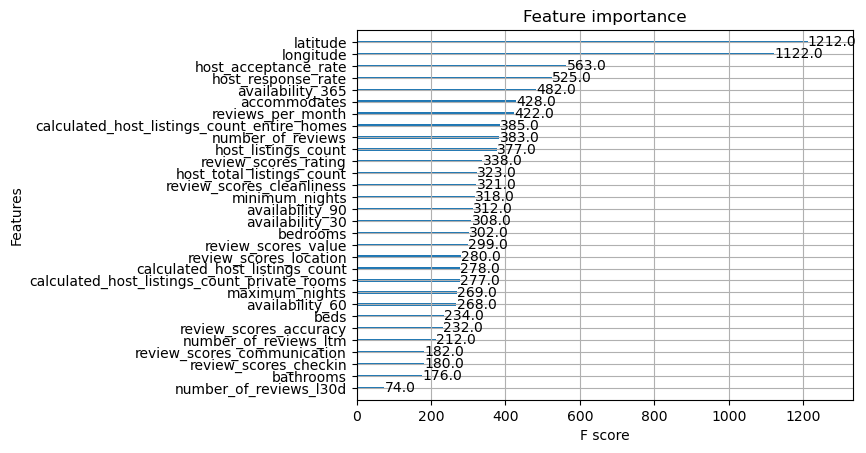

In [6]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model, max_num_features=30)
plt.show()

/tmp/ipykernel_2290837/2258278065.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)  # Fill missing data
/home/users/mas296/micromamba/envs/cs671/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:02:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1730232887822/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       539
           1       0.52      0.58      0.55       537
           2       0.47      0.43      0.45       508
           3       0.48      0.52      0.50       557
           4       0.51      0.42      0.46       477
           5       0.76      0.82      0.79       522

    accuracy                           0.60      3140
   macro avg       0.59      0.59      0.59      3140
weighted avg       0.59      0.60      0.59      3140



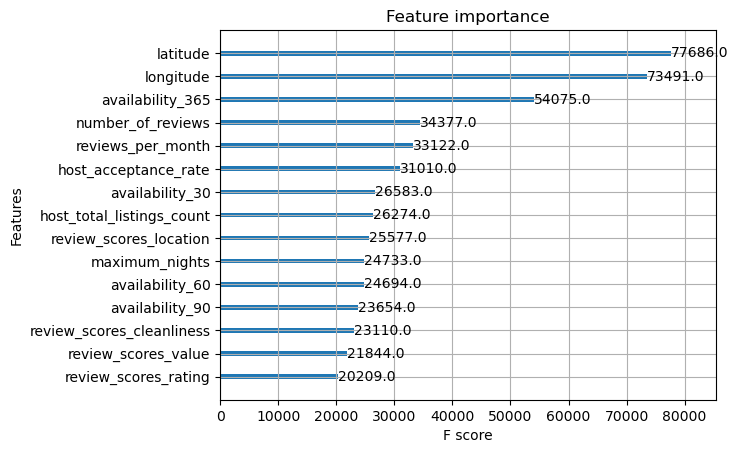

In [12]:
# Import necessary libraries
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import plot_importance

# Load dataset (assuming df is your dataset)

# Select only numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'price']  # Exclude target column

X = df[numerical_features]  # Use all numerical features
y = df['price']  # Treat price as categorical for classification

X.fillna(X.median(), inplace=True)  # Fill missing data

# Train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the XGBoost classification model
model = XGBClassifier(
    n_estimators=200,          # Increase for better performance
    learning_rate=0.02,        # Slower learning rate
    max_depth=30,               # Adjust depth to control overfitting
    subsample=0.8,             # Randomly sample rows for better generalization
    colsample_bytree=0.8,      # Randomly sample features for better generalization
    use_label_encoder=False,   # Suppress label encoding warning
    eval_metric='mlogloss',    # Multi-class log loss for evaluation
    random_state=42
)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate classification performance
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Optional: Plot feature importance
plot_importance(model, max_num_features=15)
import matplotlib.pyplot as plt
plt.show()


In [2]:
# lets do this again, adding in preprocessed categorical data
df = pd.read_csv('./data/train.csv')

# is superhost is just a binary variable
df['host_is_superhost_encoded'] = (
    df['host_is_superhost']
    .infer_objects(copy=False)
    .astype(bool)
    .astype(int)
)

# host response time is oridinal
response_time_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
df['host_response_time_encoded'] = df['host_response_time'].map(response_time_mapping)

# assume that room type is ordinal. full houses more expensive than shared rooms
room_type_mapping = {
    'Entire home/apt': 3,
    'Private room': 2,
    'Hotel room': 1,
    'Shared room': 0
}
df['room_type_encoded'] = df['room_type'].map(room_type_mapping)

# host since can be treated as continuous variable
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_years'] = 2024 - df['host_since'].dt.year

# handle bathroom type
special_cases = {
    'Half-bath': 0.5,
    'Private half-bath': 0.5,
    'Shared half-bath': 0.5
}

df['bathrooms_numeric'] = (
    df['bathrooms_text']
    .replace(special_cases)  # Replace special cases with numeric equivalents
    .str.extract(r'(\d+\.?\d*)')  # Extract numeric values (integers or decimals)
    .astype(float)  # Convert to float
)

# handle boroughs. don't worry about uncleansed neighborhood locations yet
df['neighbourhood_group_cleansed'] = df['neighbourhood_group_cleansed'].fillna(value='Unknown', method=None)

df = pd.get_dummies(df, columns=['neighbourhood_group_cleansed'], drop_first=False)


/tmp/ipykernel_2304578/3766342988.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)  # Fill missing data
/home/users/mas296/micromamba/envs/cs671/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:17:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1730232887822/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       539
           1       0.52      0.62      0.57       537
           2       0.49      0.43      0.46       508
           3       0.49      0.53      0.51       557
           4       0.51      0.44      0.47       477
           5       0.78      0.79      0.79       522

    accuracy                           0.60      3140
   macro avg       0.60      0.60      0.60      3140
weighted avg       0.60      0.60      0.60      3140



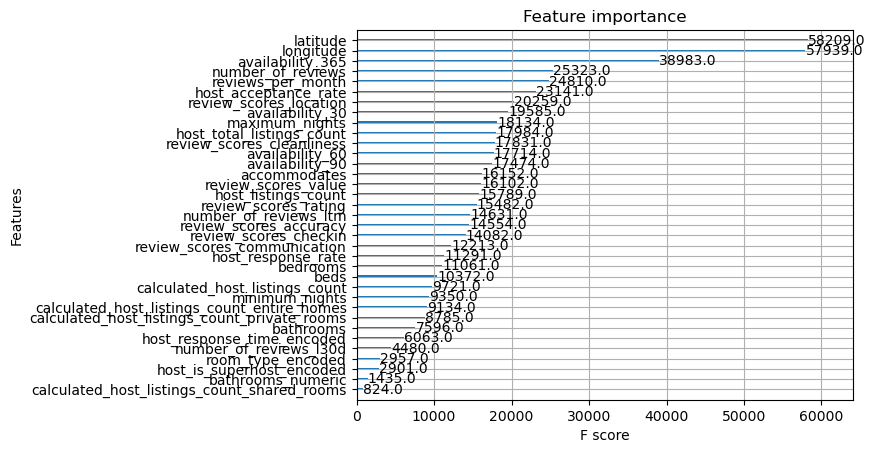

In [12]:
# Import necessary libraries
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import plot_importance

# Select only numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'price']  # Exclude target column

X = df[numerical_features]  # Use all numerical features
y = df['price']  # Treat price as categorical for classification

X.fillna(X.median(), inplace=True)  # Fill missing data

# Train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the XGBoost classification model
model = XGBClassifier(
    n_estimators=300,          # Increase for better performance
    learning_rate=0.01,        # Slower learning rate
    max_depth=12,               # Adjust depth to control overfitting
    subsample=0.8,             # Randomly sample rows for better generalization
    colsample_bytree=0.8,      # Randomly sample features for better generalization
    use_label_encoder=False,   # Suppress label encoding warning
    eval_metric='mlogloss',    # Multi-class log loss for evaluation
    random_state=42
)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate classification performance
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Optional: Plot feature importance
plot_importance(model, max_num_features=40)
import matplotlib.pyplot as plt
plt.show()


room_type_encoded                               39.274815
minimum_nights                                   9.171406
calculated_host_listings_count_private_rooms     6.290414
host_listings_count                              5.679357
accommodates                                     5.346117
bathrooms_numeric                                4.144234
calculated_host_listings_count                   3.908062
bathrooms                                        3.875726
calculated_host_listings_count_entire_homes      3.600137
bedrooms                                         2.967013
host_total_listings_count                        2.817217
longitude                                        2.398250
host_response_rate                               2.201788
beds                                             2.168147
calculated_host_listings_count_shared_rooms      2.014299
latitude                                         1.857976
availability_90                                  1.855522
host_acceptanc

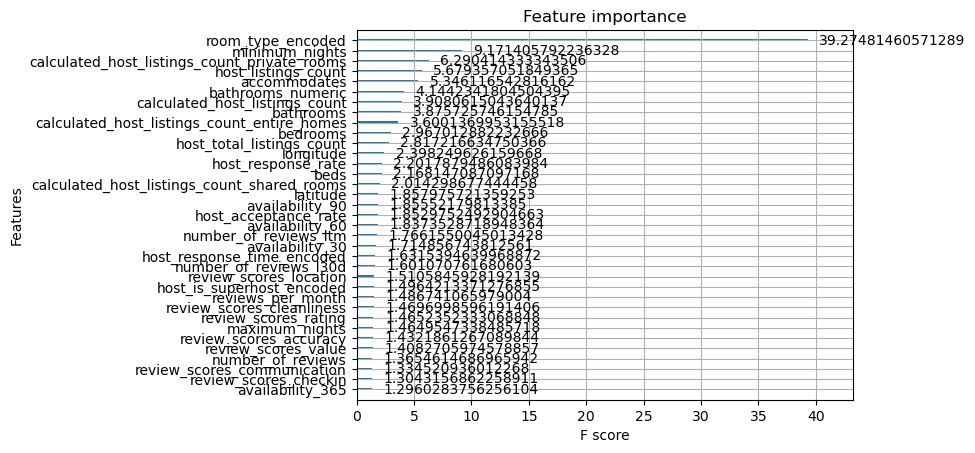

In [13]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'model' is your trained XGBoost model
importance = model.get_booster().get_score(importance_type='gain')
feature_importance = pd.Series(importance).sort_values(ascending=False)
print(feature_importance)

# Optional: Plotting the feature importance
xgb.plot_importance(model, importance_type='gain')
plt.show()


In [9]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot
shap.summary_plot(shap_values, X)


/home/users/mas296/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 